## Загрузка библиотек и функция calculate_distance_matrix

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkit as nk
import shapely
import geopandas as gpd
import shapely
import copy
import pandas as pd
import shapely.wkt
import networkx as nx
import networkit as nk

from scipy import spatial
from shapely.geometry import LineString

/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_42364/916533297.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to mi

In [2]:
def calculate_distance_matrix(road_network, houses, facilities, crs=32641, type=['walk'], weight='length_meter'):

    network = road_network.edge_subgraph(
    [(u, v, k) for u, v, k, d in road_network.edges(data=True, keys=True) 
    if d["type"] in type]
    )

    # find nearest points to objects on road network
    gdf = gpd.GeoDataFrame.from_dict(dict(network.nodes(data=True)), orient='index')
    gdf["geometry"] = gdf.apply(lambda row: shapely.geometry.Point(row.x, row.y), axis=1)
    nodes_gdf = gpd.GeoDataFrame(gdf, geometry = gdf['geometry'], crs = crs)
    from_houses = nodes_gdf['geometry'].sindex.nearest(houses['geometry'], return_distance = True, return_all = False) 
    to_facilities = nodes_gdf['geometry'].sindex.nearest(facilities['geometry'], return_distance = True, return_all = False)
    
    distance_matrix = pd.DataFrame(0, index = to_facilities[0][1], columns = from_houses[0][1])
    splited_matrix = np.array_split(distance_matrix.copy(deep = True), int(len(distance_matrix) / 1000) + 1)
    
    # conver nx graph to nk graph in oder to speed up the calculation
    nk_idmap = _get_nx2nk_idmap(network)
    net_nk =  _convert_nx2nk(network, idmap=nk_idmap, weight=weight)

    # calculate distance matrix
    for i in range(len(splited_matrix)):
        r = nk.distance.SPSP(G=net_nk, sources=splited_matrix[i].index.values).run()
        splited_matrix[i] = splited_matrix[i].apply(lambda x: _get_nk_distances(r,x), axis =1)
        del r
        
    distance_matrix = pd.concat(splited_matrix)
    distance_matrix.index = list(facilities.iloc[to_facilities[0][0]].index)
    distance_matrix.columns = list(houses.iloc[from_houses[0][0]].index)
    
    del splited_matrix

    # replace 0 values (caused by road network sparsity) to euclidian distance between two points
    distance_matrix = distance_matrix.progress_apply(lambda x: _calculate_euclidian_distance(x, houses, facilities))
    return distance_matrix


def _calculate_euclidian_distance(loc, houses, facilities):
    s = copy.deepcopy(loc)
    s_0 = s[s == 0]
    if len(s_0) > 0:
        s.loc[s_0.index] = facilities["geometry"][s.index].distance(houses["geometry"][s.name])
        return s
    else:
        return s
    

"""Functions to convert Networkx graph to Networkit graph"""

def _get_nx2nk_idmap(G_nx):
    idmap = dict((id, u) for (id, u) in zip(G_nx.nodes(), range(G_nx.number_of_nodes())))
    return idmap

def _convert_nx2nk(G_nx, idmap=None, weight=None):

    if not idmap:
        idmap = _get_nx2nk_idmap(G_nx)
    n = max(idmap.values()) + 1
    edges = list(G_nx.edges())

    if weight:
        G_nk = nk.Graph(n, directed=G_nx.is_directed(), weighted=True)
        for u_, v_ in edges:
                u, v = idmap[u_], idmap[v_]
                d = dict(G_nx[u_][v_])
                if len(d) > 1:
                    for d_ in d.values():
                            v__ = G_nk.addNodes(2)
                            u__ = v__ - 1
                            w = round(d_[weight], 1) if weight in d_ else 1
                            G_nk.addEdge(u, v, w)
                            G_nk.addEdge(u_, u__, 0)
                            G_nk.addEdge(v_, v__, 0)
                else:
                    d_ = list(d.values())[0]
                    w = round(d_[weight], 1) if weight in d_ else 1
                    G_nk.addEdge(u, v, w)
    else:
        G_nk = nk.Graph(n, directed=G_nx.is_directed())
        for u_, v_ in edges:
                u, v = idmap[u_], idmap[v_]
                G_nk.addEdge(u, v)

    return G_nk

def _get_nk_distances(nk_dists, loc):
    target_nodes = loc.index
    source_node = loc.name
    distances = [nk_dists.getDistance(source_node, node) for node in target_nodes]
    return pd.Series(data = distances, index = target_nodes)

## Загрузка необходимых файлов

In [3]:
houses = gpd.read_file("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/house_point.geojson")
facilities = gpd.read_file("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/daycare.geojson")
graph = nx.read_graphml("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/CityGeoTools-master/notebook_examples/graph.graphml", node_type=int)

In [4]:
build = gpd.read_file("/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/living_b.geojson")

In [5]:
build.head()

,id,is_living,population,storeys_count,basement_area,living_area,administrative_unit_id,municipality_id,block_id,child,geometry
0,3878462,True,138,14,521.390424,4047.600,1,1,324,41,"MULTIPOLYGON (((60.11466 55.03565, 60.11461 55..."
1,14348233,True,48,9,1634.894022,11771.237,1,1,103,14,"MULTIPOLYGON (((60.14857 55.13405, 60.14838 55..."
2,53171961,True,143,9,605.551304,3900.600,1,1,324,43,"MULTIPOLYGON (((60.11730 55.03709, 60.11741 55..."
3,53171964,True,151,9,540.696495,4494.400,1,1,272,45,"MULTIPOLYGON (((60.11650 55.03496, 60.11639 55..."
4,53171965,True,196,9,674.103745,4848.930,1,1,324,59,"MULTIPOLYGON (((60.11560 55.03694, 60.11549 55..."


## 1. Расчет матрицы расстояний

In [6]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [7]:
from tqdm.auto import tqdm
tqdm.pandas()

In [8]:
distance_matrix = calculate_distance_matrix(graph, houses, facilities)

  0%|          | 0/15881 [00:00<?, ?it/s]

In [9]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,15871,15872,15873,15874,15875,15876,15877,15878,15879,15880
0,6837.5,18525.7,7093.4,6897.4,7083.3,7183.4,7563.7,8064.7,7995.9,8026.5,...,22822.5,22786.7,22795.6,22786.7,22587.6,22896.9,22896.9,22886.5,22886.5,11129.2
1,2853.1,9477.2,2659.1,2944.5,2636.6,2653.4,2357.4,2188.5,2104.5,2028.7,...,13708.5,13672.7,13681.6,13672.7,13473.6,13782.9,13782.9,13826.3,13826.3,2305.2
2,2645.5,9433.7,2451.5,2708.4,2429.0,2445.8,2176.7,1820.4,1736.4,1660.6,...,13730.5,13694.7,13703.6,13694.7,13495.6,13804.9,13804.9,13794.5,13794.5,2151.9
3,11987.3,413.2,11795.2,12004.2,11891.2,11908.0,11636.4,11201.4,11119.4,11043.6,...,4377.9,4342.1,4351.0,4342.1,4143.0,4452.3,4452.3,4503.6,4503.6,7924.7
4,14254.9,2546.2,14062.8,14271.8,14174.1,14190.9,13921.8,13469.0,13387.0,13311.2,...,2253.8,2213.7,2226.9,2213.7,2018.9,2328.2,2328.2,2399.2,2399.2,10192.3


In [10]:
type(distance_matrix)

pandas.core.frame.DataFrame

In [11]:
distance_matrix_tr=np.transpose(distance_matrix)
distance_matrix_tr.head(20)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,6837.5,2853.1,2645.5,11987.3,14254.9,484.7,667.0,11179.6,11510.7,14815.7,...,13724.1,12669.1,3413.0,1951.4,5777.4,3321.0,3444.9,3216.3,3057.8,6531.1
1,18525.7,9477.2,9433.7,413.2,2546.2,11636.4,11428.5,620.9,469.8,3107.0,...,2015.4,1180.5,8656.8,10557.3,17465.6,15009.2,8678.3,14904.5,14746.0,18219.3
2,7093.4,2659.1,2451.5,11795.2,14062.8,385.0,612.0,10987.5,11318.6,14623.6,...,13532.0,12477.0,3220.9,1802.3,6033.3,3576.9,3250.9,3472.2,3313.7,6787.0
3,6897.4,2944.5,2708.4,12004.2,14271.8,588.9,826.2,11196.5,11527.6,14832.6,...,13741.0,12686.0,3429.9,2087.7,5837.3,3380.9,3507.8,3276.2,3117.7,6591.0
4,7083.3,2636.6,2429.0,11891.2,14174.1,268.2,544.1,11098.8,11429.9,14734.9,...,13643.3,12475.8,3337.7,1779.8,6023.2,3566.8,3228.4,3462.1,3303.6,6776.9
5,7183.4,2653.4,2445.8,11908.0,14190.9,138.8,456.4,11115.6,11446.7,14751.7,...,13660.1,12492.6,3397.1,1782.6,6123.3,3666.9,3245.2,3562.2,3403.7,6877.0
6,7563.7,2357.4,2176.7,11636.4,13921.8,430.6,278.2,10846.5,11177.6,14482.6,...,13391.0,12221.0,3218.4,1500.6,6503.6,4047.2,2976.1,3942.5,3784.0,7257.3
7,8064.7,2188.5,1820.4,11201.4,13469.0,1300.7,1148.3,10393.7,10724.8,14029.8,...,12938.2,11867.2,2627.1,1403.5,7004.6,4548.2,2619.8,4443.5,4285.0,7758.3
8,7995.9,2104.5,1736.4,11119.4,13387.0,1216.7,1064.3,10311.7,10642.8,13947.8,...,12856.2,11783.2,2545.1,1319.5,6935.8,4479.4,2535.8,4374.7,4216.2,7689.5
9,8026.5,2028.7,1660.6,11043.6,13311.2,1140.9,988.5,10235.9,10567.0,13872.0,...,12780.4,11707.4,2469.3,1243.7,6966.4,4510.0,2460.0,4405.3,4246.8,7720.1


In [12]:
# Чтобы приблизить к реальному расчету, 
# отфильтровали расстояние до среднего, сколько родителям комфортно добираться до детского садика
distance_matrix_filter = distance_matrix_tr[distance_matrix_tr < 600]
distance_matrix_filter.head(20)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,NaN,NaN,NaN,NaN,NaN,484.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,413.2,NaN,NaN,NaN,NaN,469.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,385.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,588.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,268.2,544.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,138.8,456.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,430.6,278.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Расчет Gij 

In [13]:
# суммировали строки 
row_sums = np.sum(distance_matrix_filter, axis=1)
row_sums.head(20)

0      484.7
1     1856.6
2      962.9
3     1057.0
4      812.3
5      595.2
6     1192.3
7      749.3
8     1738.1
9     1541.3
10    1738.1
11    1606.8
12    1308.8
13    1452.7
14    1409.5
15    1409.5
16    1738.1
17     749.3
18    2179.9
19     403.3
dtype: float64

In [14]:
# Определяем в таблице веса распределения 
normalized_matrix = distance_matrix_filter / row_sums[:, np.newaxis]
normalized_matrix.head()

/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_42364/3902356289.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_matrix = distance_matrix_filter / row_sums[:, np.newaxis]


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.222557,NaN,NaN,NaN,NaN,0.253043,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.399834,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.557143,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.330174,0.669826,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Проверка по строкам, sum(Gij)=1
check_row_sums = np.sum(normalized_matrix, axis=1)
check_row_sums.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

## 3. Расчет матрицы OD

In [16]:
print(houses.columns)

Index(['id', 'is_living', 'population', 'storeys_count', 'basement_area',
       'living_area', 'administrative_unit_id', 'municipality_id', 'block_id',
       'child', 'geometry'],
      dtype='object')


In [17]:
# Список ненужных столбцов
columns_to_drop = ['id', 'is_living', 'population', 'storeys_count', 'basement_area',
       'living_area', 'administrative_unit_id', 'municipality_id', 'block_id', 'geometry']

# Удаление ненужных столбцов
house_child = houses.drop(columns=columns_to_drop)

print(type(house_child))
house_child


<class 'pandas.core.frame.DataFrame'>


,child
0,41
1,14
2,43
3,45
4,59
...,...
15876,2
15877,2
15878,1
15879,1


In [18]:
# Перемножаем матрицу с весами распределений на количество детей, живущих в домах
OD = house_child['child'].values[:, np.newaxis] * normalized_matrix

result_OD = pd.DataFrame(OD)

result_OD.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,NaN,NaN,NaN,NaN,NaN,41.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,3.115803,NaN,NaN,NaN,NaN,3.542605,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,17.192855,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,25.071429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,19.480241,39.519759,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Расчет отношения емкости сервиса Sj к спросу на сервис Dij

In [19]:
# сумма по столбцам (сервисам) Dij
column_sums = np.sum(result_OD, axis=0)
column_sums.head(80)

0     384.000000
1     153.849226
2     356.726098
3     531.750210
4     611.828088
         ...    
56    290.754301
57    255.405908
58    151.245699
59    432.000000
60    359.000000
Length: 61, dtype: float64

In [20]:
print(facilities.columns)

Index(['Наименование', 'Описание', 'Рубрики', 'Адрес', 'Комментарий к адресу',
       'Почтовый индекс', 'Микрорайон', 'Район', 'Город', 'Округ', 'Регион',
       'Страна', 'Часы работы', 'Часовой пояс', 'Рейтинг',
       'Количество отзывов', 'Телефон 1', 'Телефон 2', 'Телефон 3', 'E-mail 1',
       'E-mail 2', 'Веб-сайт 1', 'Веб-сайт 2', 'ВКонтакте', 'WhatsApp 1',
       'WhatsApp 2', 'Viber', 'Telegram', 'YouTube', 'Широта', 'Долгота',
       '2GIS URL', 'Name', 'Population', 'Вместимость',
       'Макс количество детей', 'geometry'],
      dtype='object')


In [21]:
# Убираем лишнии столбцы в файле "facilities", оставляем только "Вместимость"
columns_to_drop = ['Наименование', 'Описание', 'Рубрики', 'Адрес', 'Комментарий к адресу',
       'Почтовый индекс', 'Микрорайон', 'Район', 'Город', 'Округ', 'Регион',
       'Страна', 'Часы работы', 'Часовой пояс', 'Рейтинг',
       'Количество отзывов', 'Телефон 1', 'Телефон 2', 'Телефон 3', 'E-mail 1',
       'E-mail 2', 'Веб-сайт 1', 'Веб-сайт 2', 'ВКонтакте', 'WhatsApp 1',
       'WhatsApp 2', 'Viber', 'Telegram', 'YouTube', 'Широта', 'Долгота',
       '2GIS URL', 'Name','Population',
       'Макс количество детей', 'geometry']

service = facilities.drop(columns=columns_to_drop)
#service = np.transpose(service)

print(type(service))
service

<class 'pandas.core.frame.DataFrame'>


,Вместимость
0,150
1,150
2,150
3,250
4,250
...,...
56,100
57,100
58,100
59,200


In [22]:
column_sums.name = 'Dij'

# Вывод результата
print(column_sums)

0     384.000000
1     153.849226
2     356.726098
3     531.750210
4     611.828088
         ...    
56    290.754301
57    255.405908
58    151.245699
59    432.000000
60    359.000000
Name: Dij, Length: 61, dtype: float64


In [23]:
result_df = pd.merge(service, column_sums, left_index=True, right_index=True, how='inner')
result_df

,Вместимость,Dij
0,150,384.000000
1,150,153.849226
2,150,356.726098
3,250,531.750210
4,250,611.828088
...,...,...
56,100,290.754301
57,100,255.405908
58,100,151.245699
59,200,432.000000


In [24]:
result_df['Lij'] = result_df['Вместимость'] / result_df['Dij']
columns_to_drop = ['Вместимость', 'Dij' ]
result_df = result_df.drop(columns=columns_to_drop)

print(result_df)

         Lij
0   0.390625
1   0.974981
2   0.420491
3   0.470146
4   0.408612
..       ...
56  0.343933
57  0.391534
58  0.661176
59  0.462963
60  0.557103

[61 rows x 1 columns]


In [25]:
# Создаем матрицу размерности 15881 на 61 из значений Lij
L_matrix = pd.concat([(result_df['Lij']).rename(i) for i in range(15881)], axis=1)
L_matrix

,0,1,2,3,4,5,6,7,8,9,...,15871,15872,15873,15874,15875,15876,15877,15878,15879,15880
0,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,...,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625,0.390625
1,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,...,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981,0.974981
2,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,...,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491,0.420491
3,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,...,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146,0.470146
4,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,...,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612,0.408612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,...,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933,0.343933
57,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,...,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534,0.391534
58,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,...,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176,0.661176
59,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,...,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963,0.462963


## 5. Расчет оценки обеспечености

In [26]:
# Применяем маску датафрейма resuil_OD и суммируем значения по строкам 
Accessibility = L_matrix[result_OD.T.notna()].sum()
Accessibility


0        0.369317
1        1.744456
2        0.546002
3        0.546002
4        0.698252
           ...   
15876    0.000000
15877    0.000000
15878    0.000000
15879    0.000000
15880    0.000000
Length: 15881, dtype: float64

In [27]:
# Добавляем название столбца обеспеченности
Accessibility.name = 'Accessibility'

In [28]:
# Полученный результат обеспеченности по индексу привязываем к геодатафрейму "Houses"
House_with_accessibility = pd.merge(houses, Accessibility, left_index=True, right_index=True)
House_with_accessibility

,id,is_living,population,storeys_count,basement_area,living_area,administrative_unit_id,municipality_id,block_id,child,geometry,Accessibility
0,3878462,True,138,14,521.390424,4047.600,1,1,324,41,POINT (315618.551 6102583.856),0.369317
1,14348233,True,48,9,1634.894022,11771.237,1,1,103,14,POINT (318270.781 6113459.390),1.744456
2,53171961,True,143,9,605.551304,3900.600,1,1,324,43,POINT (315776.862 6102698.800),0.546002
3,53171964,True,151,9,540.696495,4494.400,1,1,272,45,POINT (315750.039 6102502.312),0.546002
4,53171965,True,196,9,674.103745,4848.930,1,1,324,59,POINT (315705.261 6102726.473),0.698252
...,...,...,...,...,...,...,...,...,...,...,...,...
15876,1137263868,True,7,2,206.351236,330.162,1,1,0,2,POINT (319628.785 6117388.153),0.000000
15877,1137263876,True,5,2,206.353054,330.165,1,1,0,2,POINT (319618.421 6117349.176),0.000000
15878,1137263877,True,3,2,115.628514,185.006,1,1,0,1,POINT (319639.520 6117354.813),0.000000
15879,1137263879,True,3,2,115.629349,185.007,1,1,0,1,POINT (319634.448 6117322.585),0.000000


Так как "Houses" только точечный, то для наглядности оценки обеспечености по домам был добавлен файл с геометрией зданий


In [29]:
# Связывание результата оценки обеспеченности с геодатафреймом "build"
Building_with_accessibility = pd.merge(build, Accessibility, left_index=True, right_index=True, how='inner')
type(Building_with_accessibility)

geopandas.geodataframe.GeoDataFrame

In [30]:
Building_with_accessibility

,id,is_living,population,storeys_count,basement_area,living_area,administrative_unit_id,municipality_id,block_id,child,geometry,Accessibility
0,3878462,True,138,14,521.390424,4047.600,1,1,324,41,"MULTIPOLYGON (((60.11466 55.03565, 60.11461 55...",0.369317
1,14348233,True,48,9,1634.894022,11771.237,1,1,103,14,"MULTIPOLYGON (((60.14857 55.13405, 60.14838 55...",1.744456
2,53171961,True,143,9,605.551304,3900.600,1,1,324,43,"MULTIPOLYGON (((60.11730 55.03709, 60.11741 55...",0.546002
3,53171964,True,151,9,540.696495,4494.400,1,1,272,45,"MULTIPOLYGON (((60.11650 55.03496, 60.11639 55...",0.546002
4,53171965,True,196,9,674.103745,4848.930,1,1,324,59,"MULTIPOLYGON (((60.11560 55.03694, 60.11549 55...",0.698252
...,...,...,...,...,...,...,...,...,...,...,...,...
15876,1137263868,True,7,2,206.351236,330.162,1,1,0,2,"MULTIPOLYGON (((60.16804 55.17022, 60.16801 55...",0.000000
15877,1137263876,True,5,2,206.353054,330.165,1,1,0,2,"MULTIPOLYGON (((60.16791 55.16987, 60.16787 55...",0.000000
15878,1137263877,True,3,2,115.628514,185.006,1,1,0,1,"MULTIPOLYGON (((60.16817 55.16981, 60.16801 55...",0.000000
15879,1137263879,True,3,2,115.629349,185.007,1,1,0,1,"MULTIPOLYGON (((60.16811 55.16952, 60.16795 55...",0.000000


In [31]:
Building_with_accessibility.to_file("Building_with_accessibility.geojson", driver='GeoJSON')

## Визуализация результата

In [32]:
import folium
from branca.colormap import LinearColormap

In [33]:
polygons_gdf = Building_with_accessibility

In [34]:
m = folium.Map(location=[polygons_gdf['geometry'].centroid.y.mean(), polygons_gdf['geometry'].centroid.x.mean()],
               zoom_start=12, tiles='cartodb positron')

colormap = LinearColormap(colors=['red', 'yellow', 'green'],
                           vmin=polygons_gdf['Accessibility'].min(),
                           vmax=polygons_gdf['Accessibility'].max())

folium.GeoJson(
    polygons_gdf,
    name='Accessibility',
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Accessibility']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    },
    highlight_function=lambda x: {'weight': 2, 'color': 'black'},
    smooth_factor=2.0,
    tooltip=folium.GeoJsonTooltip(fields=['Accessibility'],
                                   aliases=['Accessibility'],
                                   labels=True,
                                   sticky=True)
).add_to(m)

colormap.add_to(m)

m.save('Accessibility.html')

/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_42364/823938538.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[polygons_gdf['geometry'].centroid.y.mean(), polygons_gdf['geometry'].centroid.x.mean()],
/var/folders/bx/v3mbx_q14t33bw38fmk9hxq00000gn/T/ipykernel_42364/823938538.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[polygons_gdf['geometry'].centroid.y.mean(), polygons_gdf['geometry'].centroid.x.mean()],


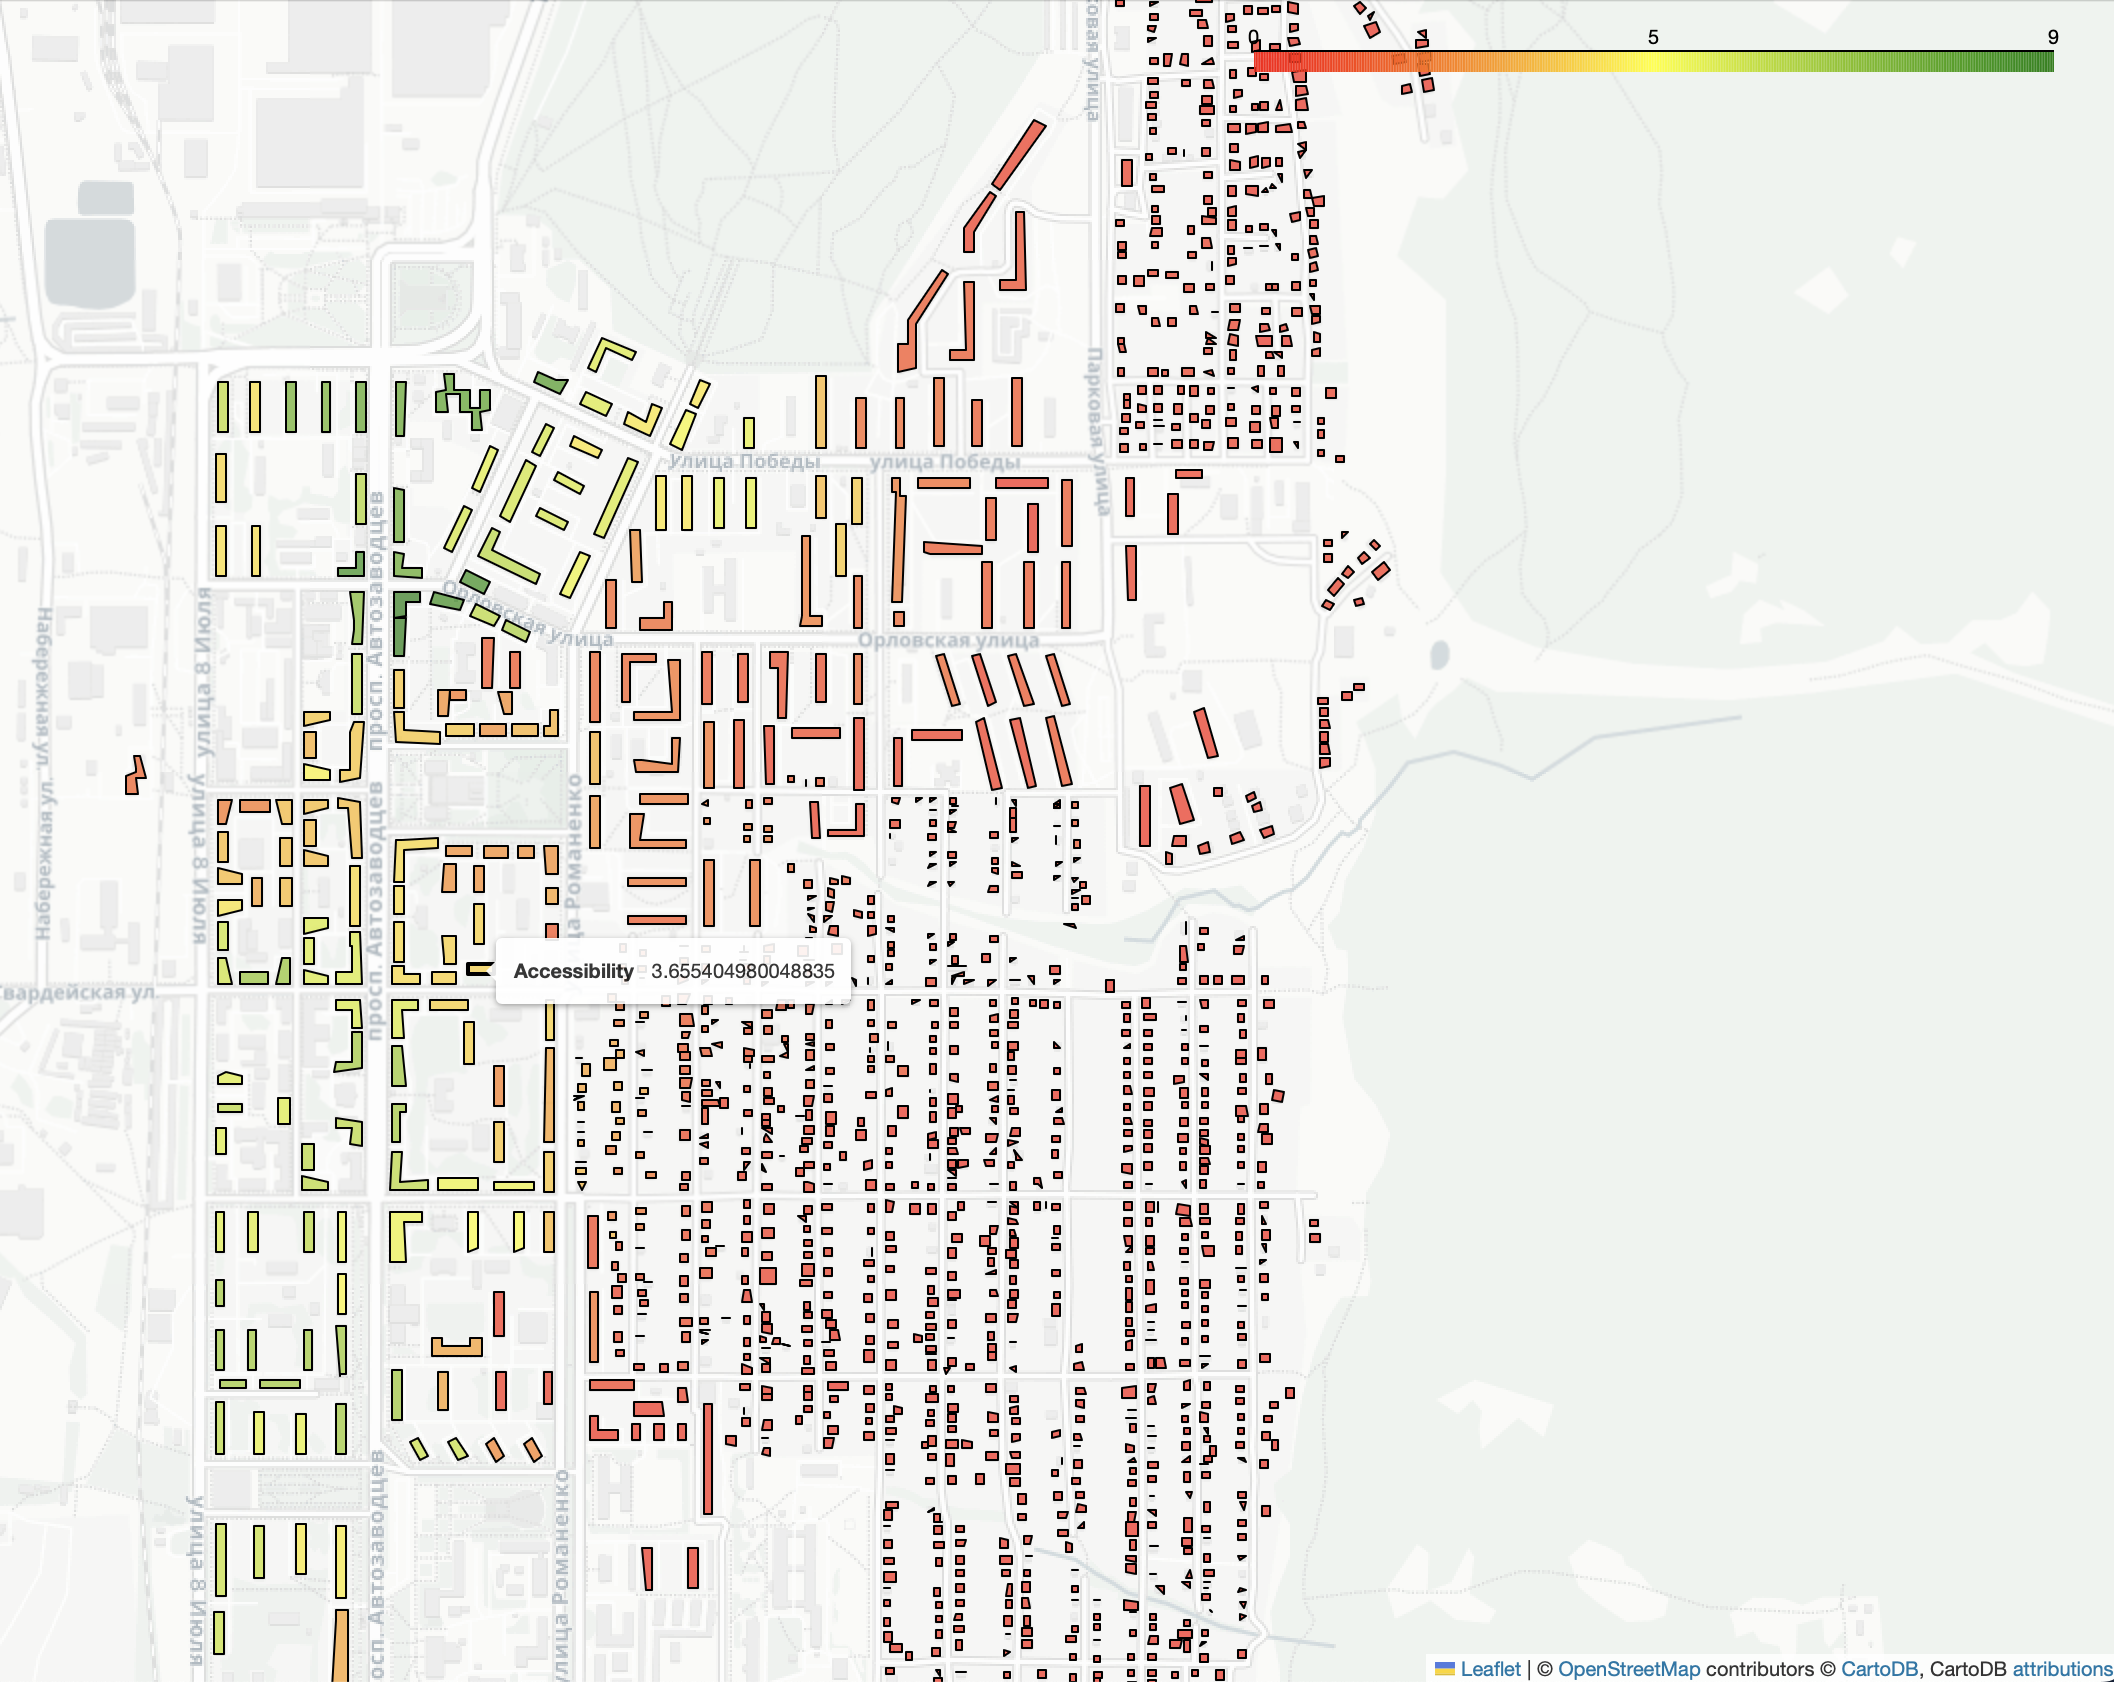

In [35]:
from IPython.display import Image, display
display(Image(filename='/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/Снимок экрана 2023-12-12 в 13.54.56.png', embed=True))

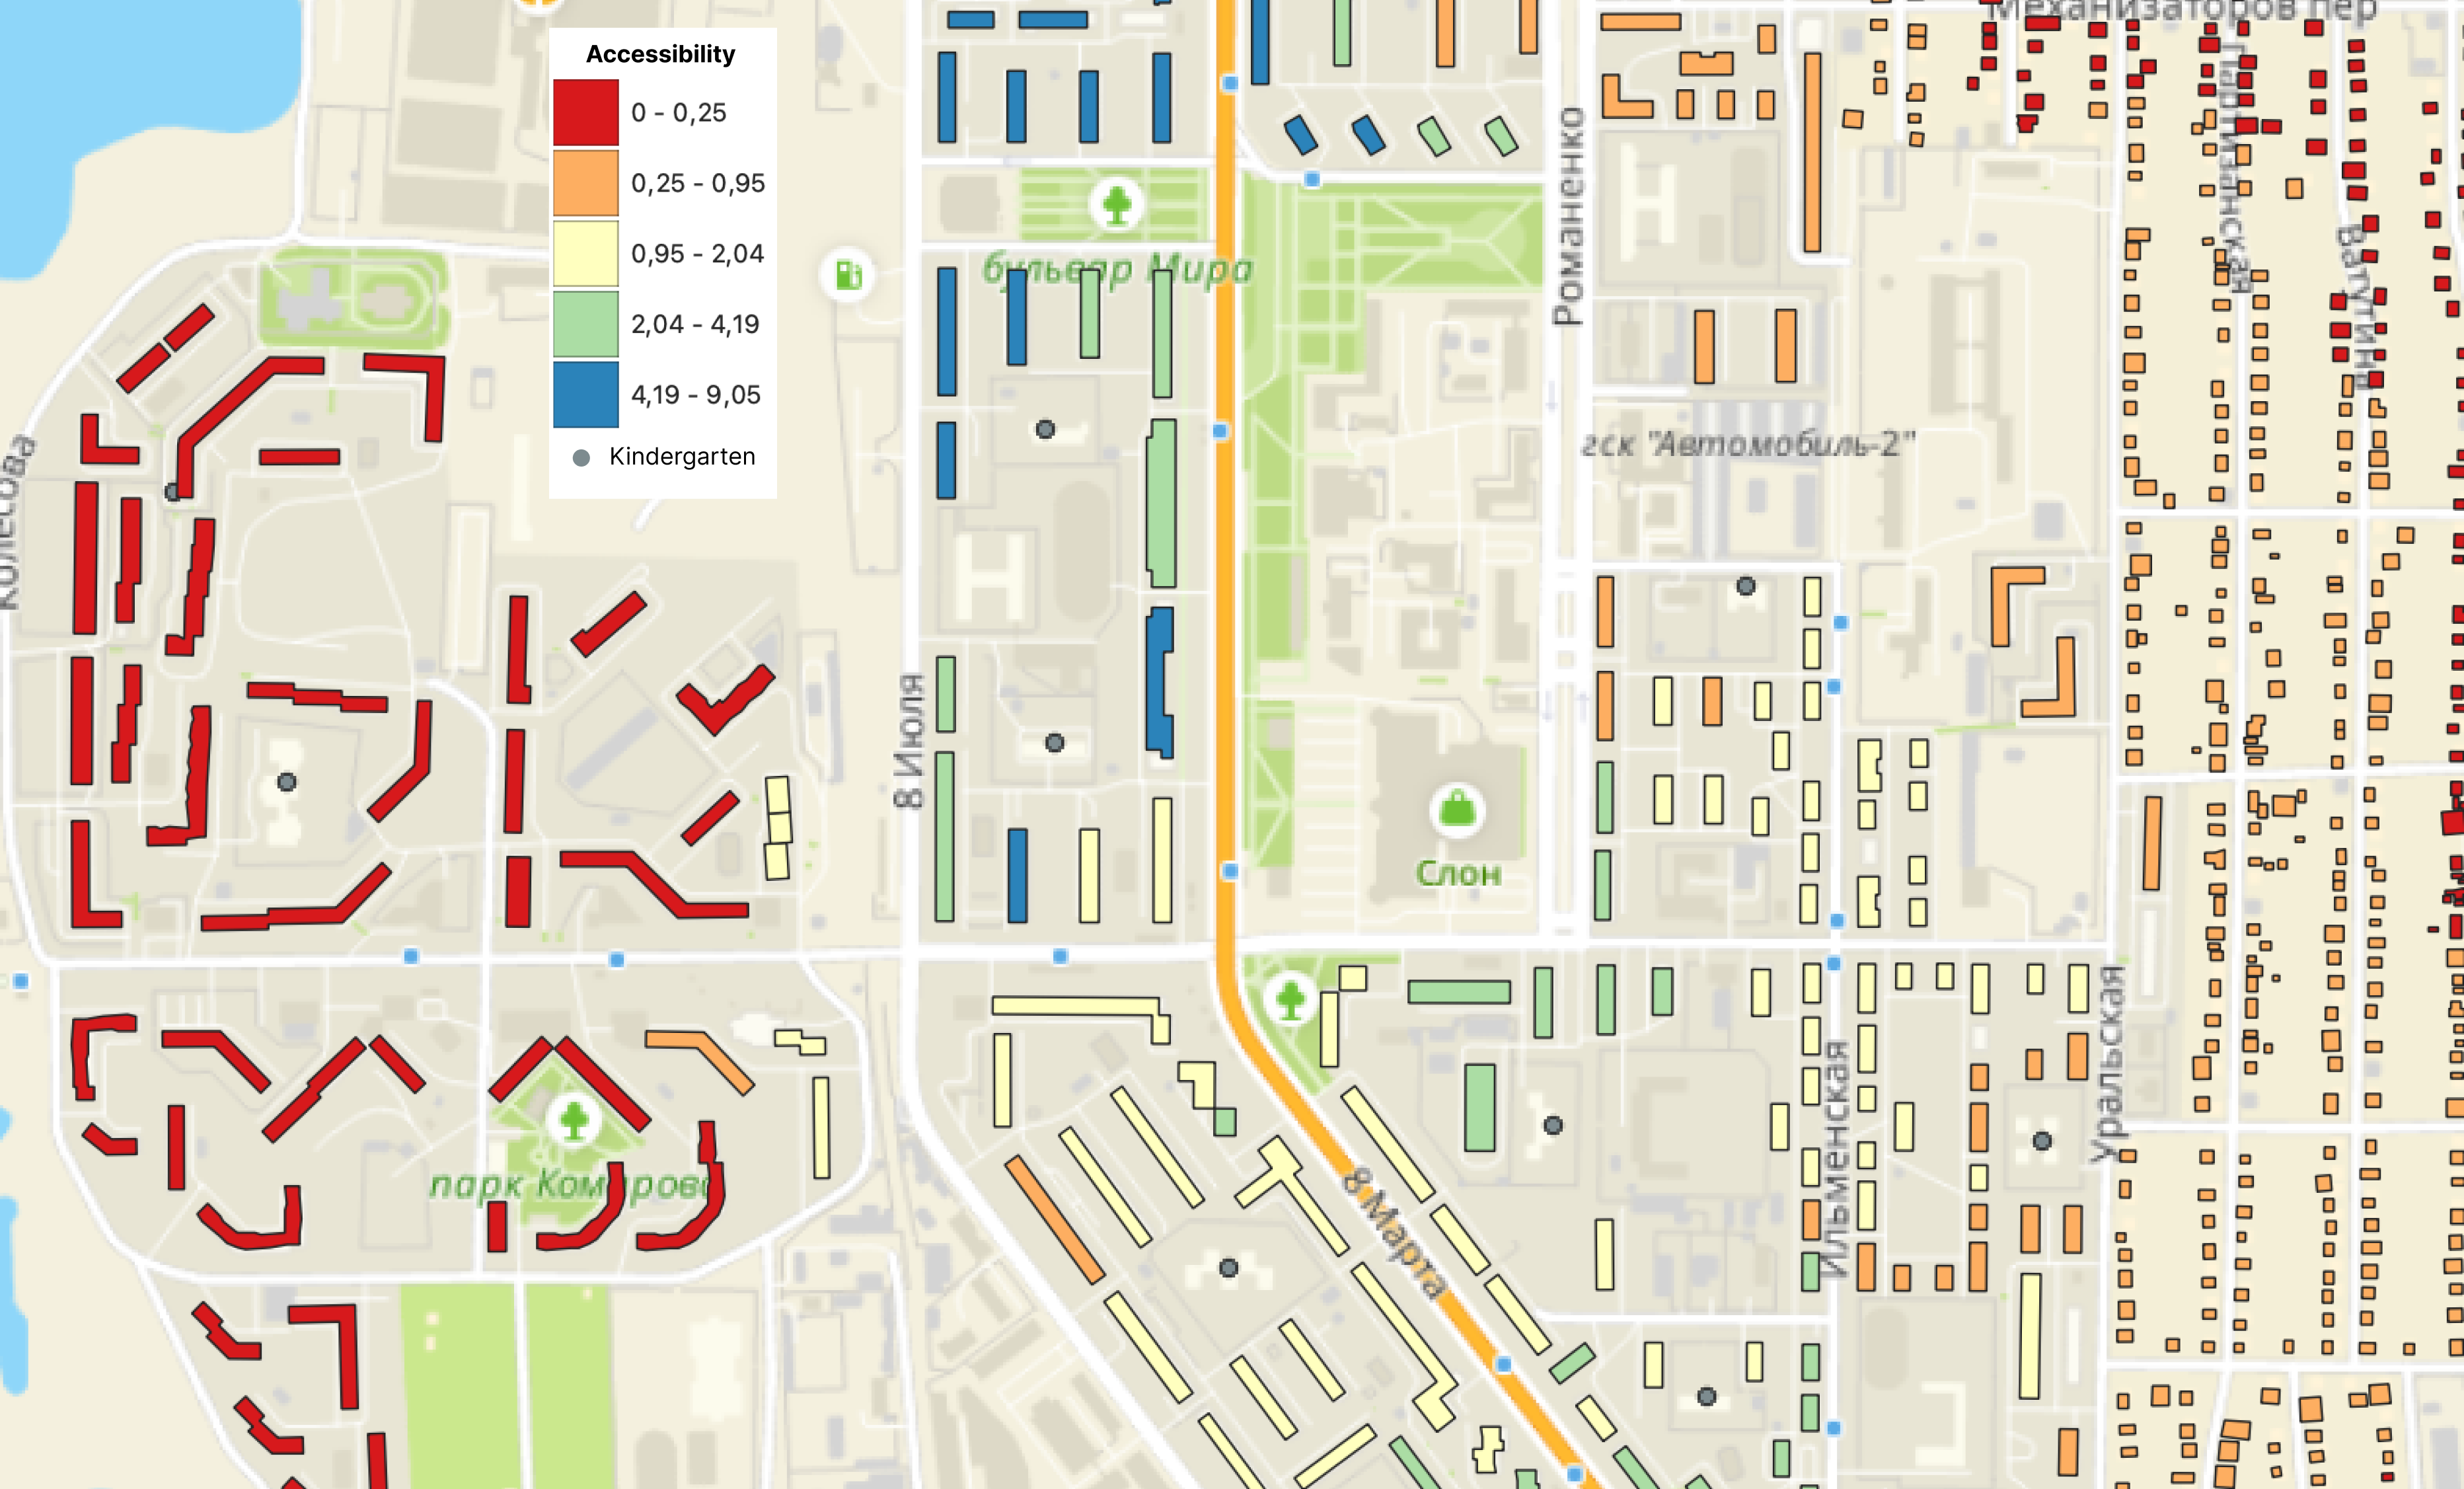

In [36]:
display(Image(filename='/Users/lizzy/Documents/ИТМО/Прикладные методы анализа ГД/Online/Group 216.png', embed=True))

## Выводы

Анализируя полученный результат мы видим, что дома, находящиеся в радиусе (изохроне) 600 мнтров от детских садов будут обеспеченны местами. Дома располагающиеся дальше 600 метров обеспеченны не будут совсем. Отсюда выползает и недостаток данного метода. Он рассчитывает лишь в радиусе заданном в начале, а дома, непопавшие в зону обеспеченности получат оценку 0. 

Второй недостаток  - это неучет перегруженности сервиса. Соотвественно данный метод показывает максимальную загрузку сервиса зависящей от спроса. И в результате мы видим лишь ответ на вопрос: хватает емкости садика чтобы обеспечить дома в радиусе или нет. В жизни же если садик заполнен, то дети из необеспеченного местами дома будут загружать другой садик, который имеет свободные места и готовый их принять. 